# Seminar 1. Introduction to spiking neural networks
## In class:
* Brian2 simulator basics (https://brian2.readthedocs.io): units, neuron group, ODE, plots
* Modeling neurons: spikes and refractoriness
* Leaky integrate and fire
* Input current and spike generators
* Integrate and fire with adaptation
* I-f curve
* Networks in Brian. Synapses


## Homework
### Excersise 1 (Simple pattern recognition)
Here we model an "artificial retina" which is able to detect orientation of the presented bars. 
The input is a 3x3 matrix I where I(i,j) is the light intensity at the point with coordinates (i,j):

* Create a two-layer network where first layer is "receptor" neurons which transforms the I(i,j) input to the spike frequency. 
* Each neuron of the second layer receives 9 inputs from each "receptor". 
* Each neuron should encode one orientation: vertical, horizontal, diagonal.

### Excercise 2 (Population coding)
Modify the previous example such that the orientation is encoded by the frequency of total neural activity 

### Brian2 basics
https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html
* Units: volts, seconds, amp etc.
* Equations
* Neuron group
* Monitoring

In [1]:
%matplotlib inline
import brian2 as b2
import numpy as np

In [25]:
import matplotlib.pyplot as plt

def plot_v(v_mon, v_threshold=None, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.plot(v_mon.t/b2.ms, v_mon.v[0]/b2.mvolt, label='Membrane voltage')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)')
    if v_threshold:
        ax.axhline(v_threshold/b2.mvolt, ls='--', c='C2', label='threshold') #plot threshold
        
def plot_spikes(s_mon, ax=None):
    if ax is None:
        ax = plt.gca()

    for t in s_mon.t:
        ax.axvline(t/b2.ms, ls='--', c='C1', lw=3)

def plot_I(mon, current, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('I (nA)')
    ax.plot(mon.t / b2.ms, current(mon.t)/b2.namp, "r", lw=2, label='Input current') 
    
def plot_v_spikes(v_mon, s_mon, t_bounds=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    b2.plot(v_mon.t/b2.ms, v_mon.v[0], label='left')
    b2.plot(v_mon.t/b2.ms, v_mon.v[1], label='right')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num')     

Before v=-65. mV
After v=-50.000681 mV
Expected value of v = -49.99773 mV


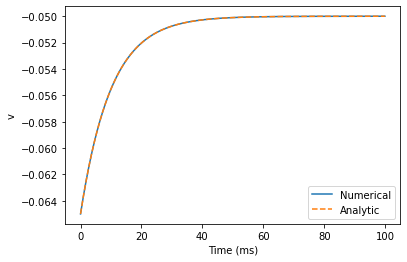

In [26]:
b2.start_scope() # clear the Brian scope
tau = 10*b2.ms #milliseconds
v_rest = -50 * b2.mvolt #millivolts
v0 = -65 * b2.mvolt
T = 100 * b2.ms
# in ODE line the units must be SI like volts, s, amp
eqs ='''
dv/dt=(v_rest-v)/tau : volt
'''
G = b2.NeuronGroup(1, eqs, method='linear')
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
print("Before v=%s" % G.v[0])
b2.run(T)
print("After v=%s" % G.v[0])
exp_v = v_rest*(1-b2.exp(-T/tau))
print('Expected value of v = %s' % exp_v)
b2.plot(M.t/b2.ms, M.v[0], label='Numerical')
b2.plot(M.t/b2.ms, v_rest + (v0-v_rest)*b2.exp(-M.t/tau), 'C1--',label='Analytic')
b2.xlabel('Time (ms)')
b2.ylabel('v')
b2.legend();

### Neurons
* input current
* spikes and reset
* refractoriness

https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html#adding-spikes

Spike times: [ 13.8  30.9  48.   65.1  82.2  99.3 116.4 133.5 150.6 167.7 184.8] ms
Frequency: 55. Hz


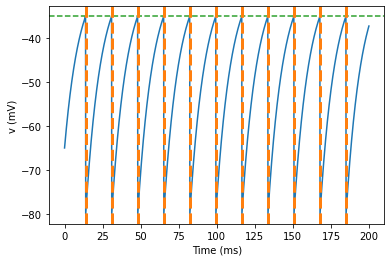

In [27]:
b2.start_scope()
tau = 10*b2.ms #milliseconds
v_rest = -65 * b2.mvolt #millivolts
v0 = -65 * b2.mvolt
v_th = -35 * b2.mvolt
v_reset = -80 * b2.mvolt
R = 10 * b2.Mohm
I = 4 * b2.namp
T = 200 * b2.ms
# in ODE line the units must be SI like volts, s, amp
eqs ='''
dv/dt=(v_rest-v)/tau + R*I/tau: volt
'''
G = b2.NeuronGroup(1,eqs,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='exact')
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)
plot_v(M, v_th)
print('Spike times: %s' % spikemon.t[:])
print('Frequency: %s' % str(spikemon.count[0]/T))

plot_spikes(spikemon)

### Refractoriness
After a spike the neuron enters the refractory period and cannot fire new spikes.

Spike times: [  0.  22.  44.  66.  88. 110. 132. 154. 176. 198.] ms
Frequency: 50. Hz


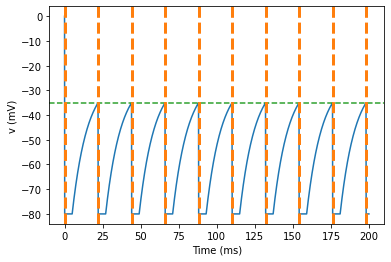

In [28]:
# add refractory period
b2.start_scope()
tau_ref = 5 * b2.ms
eqs ='''
dv/dt=(v_rest-v)/tau + R*I/tau: volt (unless refractory)
'''
G = b2.NeuronGroup(1,eqs,
                   threshold='v>v_th', 
                   reset='v = v_reset',
                   refractory = tau_ref,
                   method='exact')
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)
plot_v(M, v_th)
print('Spike times: %s' % spikemon.t[:])
print('Frequency: %s' % str(spikemon.count[0]/T))
plot_spikes(spikemon)

### Time-dependent input
Here is the example of step current with increasing amplitute

#### Exercise 1
Explore how the spiking frequency of a LIF neuron depends on the amplitude of the step current. 
Plot I-f curve where current is along x-axis and frequency is along y-axis

___
An input current is set for each timestep, see I_arr. We look at V dependency and spikes.

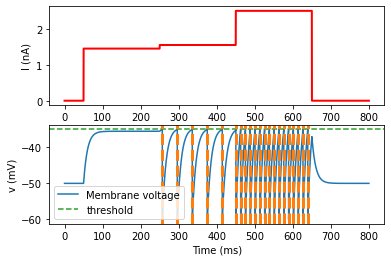

In [29]:
import numpy as np
b2.start_scope()

R = 10. * b2.Mohm # membrane resistance 
tau = 10*b2.ms # membrane time scale

v_rest = -50 * b2.mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * b2.mvolt # threshold
v_reset = -60 * b2.mvolt # reset potential

T = 800 * b2.ms # simulation time

# Create input current
I_subthres = 1.45
I_low = 1.55
I_high = 2.5

#Step input
I_arr = [0]*5 + [I_subthres]*20 + [I_low]*20 + [I_high]*20 +[0]
I = b2.TimedArray(I_arr * b2.namp, dt=10 * b2.ms)

#Periodic input
# ?
# I = b2.TimedArray(I_arr * b2.namp, dt=1 * b2.ms)
eqs ='''
dv/dt=(v_rest-v)/tau + R*I(t)/tau : volt
'''
G = b2.NeuronGroup(
    1,eqs,
    threshold='v>v_th', 
    reset='v = v_reset', 
    method='linear'
)
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)

_,(ax_I, ax_V) = plt.subplots(2,1)
plot_I(M, I, ax=ax_I)
plot_v(M, v_th, ax=ax_V)
plot_spikes(spikemon, ax=ax_V)
plt.legend()

Just another input current example.

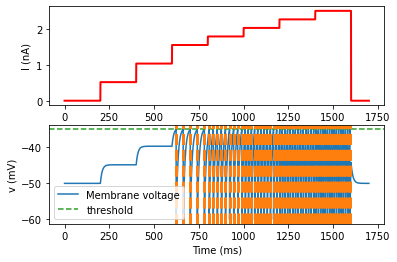

In [31]:
import numpy as np
b2.start_scope()

R = 10. * b2.Mohm # membrane resistance 
tau = 10*b2.ms # membrane time scale

v_rest = -50 * b2.mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * b2.mvolt # threshold
v_reset = -60 * b2.mvolt # reset potential

T = 1700 * b2.ms # simulation time

# Create input current
I_subthres = 1.45
I_low = 1.55
I_high = 2.5

currents = np.concatenate((
    np.linspace(0., I_low, num=3, endpoint=False),
    np.linspace(I_low, I_high, num=5, endpoint=True),
    [0]
))

#Step input
I_arr = currents
# I_arr = np.repeat(currents, 20)
# I_arr = [0]*5 + [I_subthres]*20 + [I_low]*20 + [I_high]*20 + [1]
I = b2.TimedArray(I_arr * b2.namp, dt=200 * b2.ms)

#Periodic input
# ?
# I = b2.TimedArray(I_arr * b2.namp, dt=1 * b2.ms)
eqs ='''
dv/dt=(v_rest-v)/tau + R*I(t)/tau : volt
'''
G = b2.NeuronGroup(
    1,eqs,
    threshold='v>v_th', 
    reset='v = v_reset', 
    method='linear'
)
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)

_,(ax_I, ax_V) = plt.subplots(2,1)
plot_I(M, I, ax=ax_I)
plot_v(M, v_th, ax=ax_V)
plot_spikes(spikemon, ax=ax_V)
plt.legend()

We study how spike frequency depends on an input current (we calc freq for each input value from a range) – I-f plot

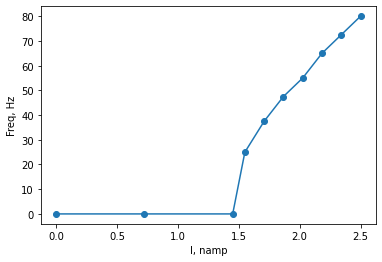

In [33]:
import numpy as np
b2.start_scope()

R = 10. * b2.Mohm # membrane resistance 
tau = 10*b2.ms # membrane time scale

v_rest = -50 * b2.mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * b2.mvolt # threshold
v_reset = -60 * b2.mvolt # reset potential

T = 400 * b2.ms # simulation time

# Create input current
I_subth, I_low, I_high = 1.45, 1.55, 2.5
I_arr = np.concatenate((
    np.linspace(0., I_subth, num=3, endpoint=True),
    np.linspace(I_low, I_high, num=7, endpoint=True),
#     [0]
))

frequencies = []
for I in I_arr:
    I = I * b2.namp
    
    eqs ='''
    dv/dt=(v_rest-v)/tau + R*I/tau : volt
    '''
    G = b2.NeuronGroup(
        1,eqs,
        threshold='v>v_th', 
        reset='v = v_reset', 
        method='linear'
    )

    G.v = v0
    M = b2.StateMonitor(G, 'v', record=True)
    spike_mon = b2.SpikeMonitor(G)
    b2.run(T)
    
    freq = len(spike_mon.t) / T
    frequencies.append((I, freq))

xs, ys = zip(*frequencies)
xs, ys = np.array(xs), np.array(ys)
xs /= b2.namp


plt.xlabel('I, namp')
plt.ylabel('Freq, Hz')
plt.scatter(xs, ys)
plt.plot(xs, ys)

#### Exercise 2
Implement sinusoidal current and see how the neuron reacts. Print the spiking frequency

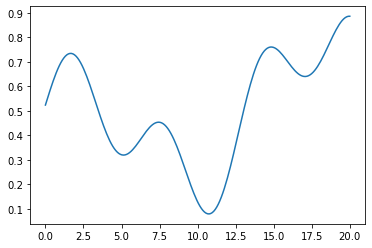

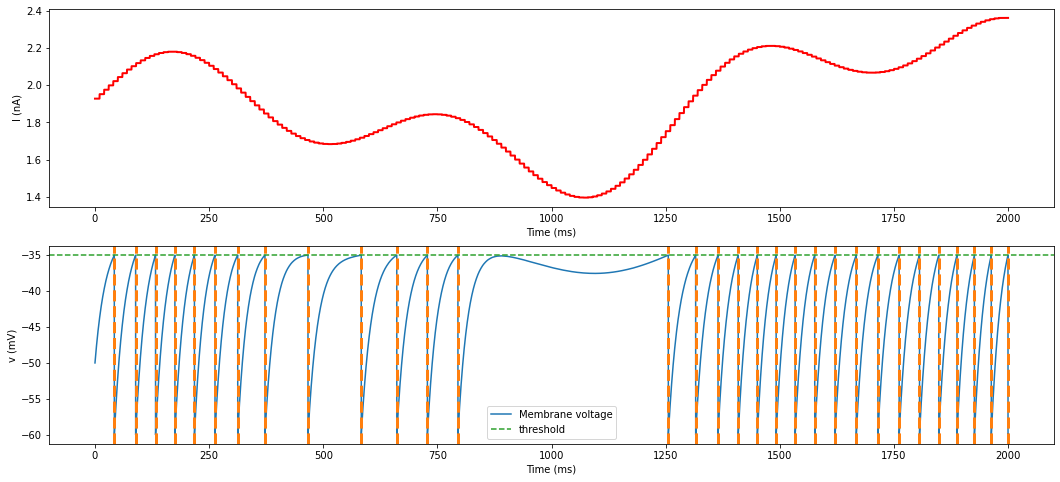

In [46]:
import numpy as np
b2.start_scope()

R = 10. * b2.Mohm # membrane resistance 
tau = 10*b2.ms # membrane time scale

v_rest = -50 * b2.mvolt # rest potential 
v0 = v_rest # initial potential
v_th = -35 * b2.mvolt # threshold
v_reset = -60 * b2.mvolt # reset potential

T = 2000 * b2.ms # simulation time

# Create input current
I_subthres = 1.3
I_low = 1.55
I_high = 2.5

#Step input
ts = np.linspace(0., 20., int(T/tau)).reshape((-1, 1))
sins_a = np.array([.0, 0., 3.])
sins = np.array([1., .45, .25])
sin_cum = np.mean((1 + np.sin(sins_a + ts * sins)) / 2, axis=-1)

I_arr = I_subthres + (I_high - I_subthres) * sin_cum
plt.plot(ts, sin_cum)
I = b2.TimedArray(I_arr * b2.namp, dt=10 * b2.ms)

#Periodic input
# I = b2.TimedArray(I_arr * b2.namp, dt=1 * b2.ms)
eqs ='''
dv/dt=0.45*(v_rest-v)/tau + 0.4*R*I(t)/tau : volt
'''
G = b2.NeuronGroup(
    1,eqs,
    threshold='v>v_th', 
    reset='v = v_reset', 
    method='linear'
)
G.v = v0
M = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)

_,(ax_I, ax_V) = plt.subplots(2,1, figsize=(18, 8))
plot_I(M, I, ax=ax_I)
plot_v(M, v_th, ax=ax_V)
plot_spikes(spikemon, ax=ax_V)
plt.legend()

Compare firing rate in parallel compared to doing it sequentially above. Now we set different input current (or actually target voltage) for neurons in a population.

WARNING    'v0' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


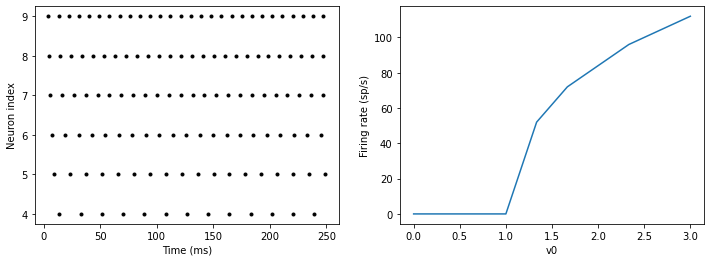

In [48]:
b2.start_scope()

N = 10
tau = 10*b2.ms
v0_max = 3.
duration = 250*b2.ms

eqs = '''
v0 : 1
dv/dt = (v0-v)/tau : 1 (unless refractory)
'''

G = b2.NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*b2.ms, method='exact')
M = b2.SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

b2.run(duration)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(M.t/b2.ms, M.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(122)
plt.plot(G.v0, M.count/duration)
plt.xlabel('v0')
plt.ylabel('Firing rate (sp/s)');

The same plus stochastic variable `xi`, which is normal gaussian

WARNING    "v0" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


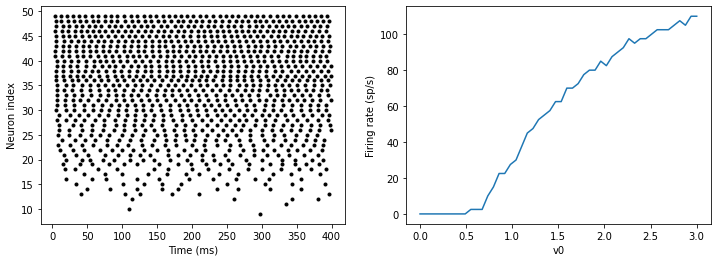

In [11]:
b2.start_scope()

N = 50
tau = 10*b2.ms
v0_max = 3.
sigma = 0.2
duration = 400*b2.ms

eqs = '''
dv/dt = (v0-v)/tau + sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

G = b2.NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*b2.ms, method='euler')
M = b2.SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

b2.run(duration)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(M.t/b2.ms, M.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(122)
plt.plot(G.v0, M.count/duration)
plt.xlabel('v0')
plt.ylabel('Firing rate (sp/s)');

Leaky IF neuron with adaptive threshold `vt` (which is also has a decay). Plots: `v`, `vt`, instant firing rate, spikes for population.

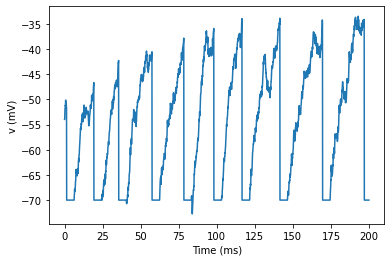

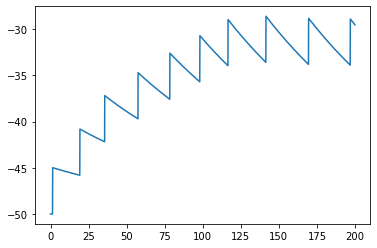

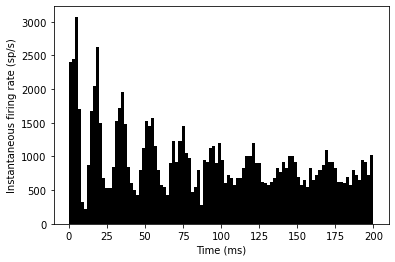

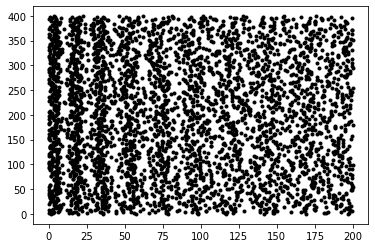

In [51]:
b2.start_scope()

N = 400
tau = 10*b2.ms
vr = -70*b2.mV
vt0 = -50*b2.mV
delta_vt0 = 5*b2.mV
tau_t = 100*b2.ms
sigma = 0.3*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 200*b2.ms

# eqs = '''
# dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt (unless refractory)
# dvt/dt = (vt0-vt)/tau_t : volt
# '''

eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt (unless refractory)
dvt/dt = (vt0-vt)/tau_t : volt
'''


reset = '''
v = vr
vt += delta_vt0
'''

G = b2.NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*b2.ms, method='euler')
M = b2.SpikeMonitor(G)
SM = b2.StateMonitor(G, ['v', 'vt'], record=0)

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

b2.run(duration)
plot_v(SM)
plt.show()
plt.plot(SM.t/b2.ms, SM.vt[0]/b2.mV)
plt.show()

ws = np.ones(len(M))/(N*b2.defaultclock.dt)
_ = plt.hist(M.t/b2.ms, 100, histtype='stepfilled', facecolor='k', weights=ws)
plt.xlabel('Time (ms)')
plt.ylabel('Instantaneous firing rate (sp/s)');
plt.show()

plt.plot(M.t/b2.ms, M.i, '.k')

### Synapses in Brian2
https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html

In [52]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    b2.figure(figsize=(10, 4))
    b2.subplot(121)
    b2.plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    b2.plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        b2.plot([0, 1], [i, j], '-k')
    b2.xticks([0, 1], ['Source', 'Target'])
    b2.ylabel('Neuron index')
    b2.xlim(-0.1, 1.1)
    b2.ylim(-1, max(Ns, Nt))
    b2.subplot(122)
    b2.plot(S.i, S.j, 'ok')
    b2.xlim(-1, Ns)
    b2.ylim(-1, Nt)
    b2.xlabel('Source neuron index')
    b2.ylabel('Target neuron index')

Three neurons connected. 0 to [1, 2] connections are excitatory, 1 to 2 and 2 to 1 connections are inhibitory. The voltage plot shows how Neuron2 inhibits Neuron1 by firing the first.
Another difference between 1 and 2 is the weight of connection and the delay of excitation.

WARNING    'I' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value <Function>. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


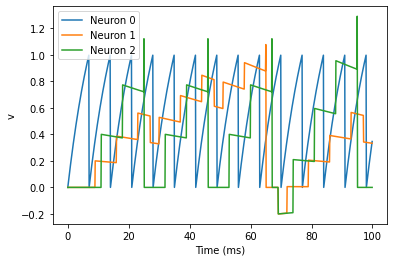

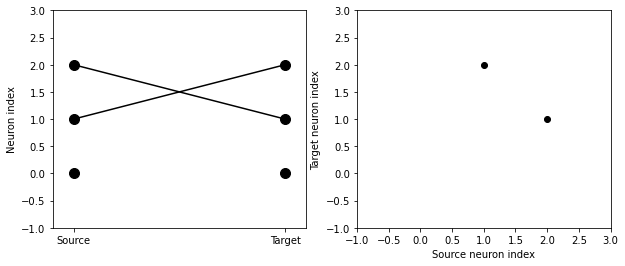

In [53]:
b2.start_scope() # clear the Brian scope

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = b2.NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*b2.ms

# Comment these two lines out to see what happens without Synapses
S = b2.Synapses(G, G, 'w: 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j * .2'
S.delay = 'j*2*ms'

S_inh = b2.Synapses(G, G, 'w: 1', on_pre='v_post -= w')
S_inh.connect(i=[1, 2], j=[2, 1])
S_inh.w = .2
S_inh.delay = 'j*2*ms'

M = b2.StateMonitor(G, 'v', record=True)

b2.run(100*b2.ms)

for i in range(len(M.v)):
    plt.plot(M.t/b2.ms, M.v[i], label=f'Neuron {i}')
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.legend();
plt.show()

visualise_connectivity(S_inh)

An example of how connections could be defined.

WARNING    'i' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


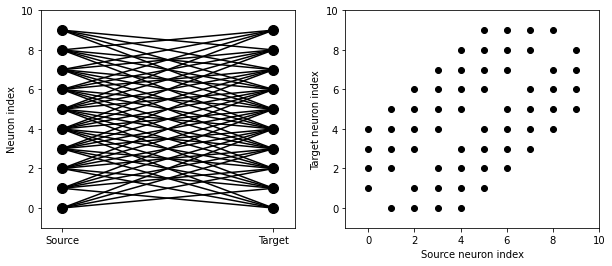

In [54]:
N = 10
G = b2.NeuronGroup(N, 'v:1')

S = b2.Synapses(G, G)
S.connect(condition='(i - j)**2<25 and i!=j')
visualise_connectivity(S)

Even more complex connections topology – weights depend on the distance between neurons

WARNING    'i' is an internal variable of group 'neurongroup_5', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


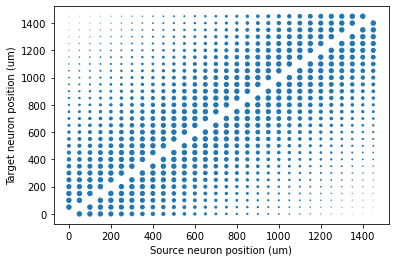

In [55]:
b2.start_scope()
N = 30
neuron_spacing = 50*b2.umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = b2.NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = b2.Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

plt.scatter(S.x_pre/b2.um, S.x_post/b2.um, S.w*20)
plt.xlabel('Source neuron position (um)')
plt.ylabel('Target neuron position (um)');

The plot of weight change base on STDP rule

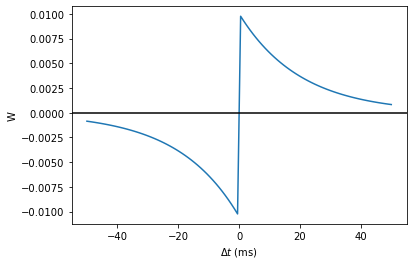

In [62]:
tau_pre = tau_post = 20*b2.ms
A_pre = 0.01
A_post = -A_pre*1.05

delta_t = np.linspace(-50, 50, 100)*b2.ms
W = np.where(delta_t>0, A_pre*np.exp(-delta_t/tau_pre), A_post*np.exp(delta_t/tau_post))
plt.plot(delta_t/b2.ms, W)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('W')
plt.axhline(0, ls='-', c='k');

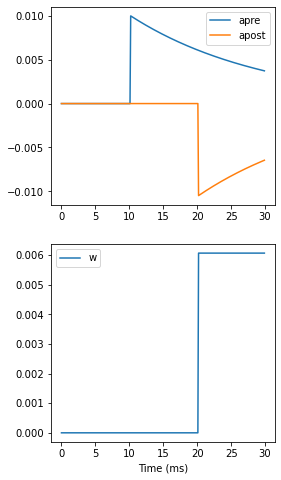

In [30]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(
    G, G,
    '''
    w : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',
    on_pre='''
    v_post += w
    apre += Apre
    w = clip(w+apost, 0, wmax)
    ''',
    on_post='''
    apost += Apost
    w = clip(w+apre, 0, wmax)
    ''', 
    
    method='linear'
)
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

In [63]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(
    G, H,
    '''
    w : 1
    dapre/dt = -apre/taupre : 1 (event-driven)
    dapost/dt = -apost/taupost : 1 (event-driven)
    ''',
    on_pre='''
    apre += Apre
    w = w+apost
    ''',
    on_post='''
    apost += Apost
    w = w+apre
    '''
)
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');

NameError: name 'start_scope' is not defined

### Tutorial #3

CPU times: user 17 s, sys: 46.1 ms, total: 17.1 s
Wall time: 17.1 s


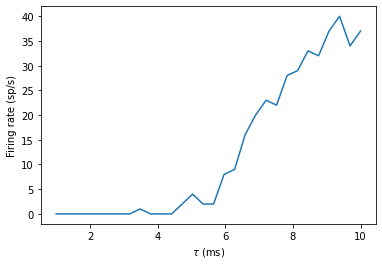

In [33]:
%%time
# remember, this is here for running separate simulations in the same notebook
start_scope()
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# Range of time constants
tau_range = linspace(1, 10, 30)*ms
# Use this list to store output rates
output_rates = []
# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

CPU times: user 15.1 s, sys: 35.2 ms, total: 15.1 s
Wall time: 15.2 s


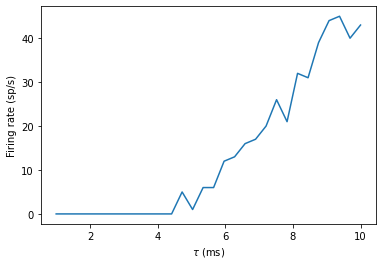

In [35]:
%%time
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

CPU times: user 14.3 s, sys: 95.5 ms, total: 14.4 s
Wall time: 24 s


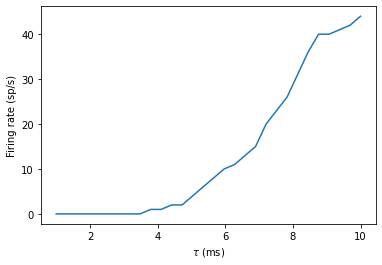

In [37]:
%%time

start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

WARNING    "tau" is an internal variable of group "neurongroup_7", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


CPU times: user 910 ms, sys: 59.9 ms, total: 970 ms
Wall time: 2.16 s


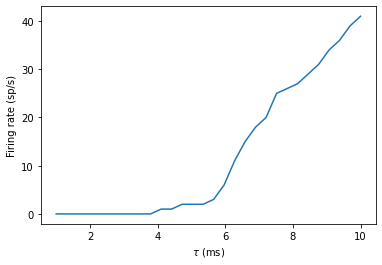

In [38]:
%%time
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
num_tau = len(tau_range)
P = PoissonGroup(num_inputs, rates=input_rate)
# We make tau a parameter of the group
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''
# And we have num_tau output neurons, each with a different tau
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Now we can just run once with no loop
run(1*second)
output_rates = M.count/second # firing rate is count/duration
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

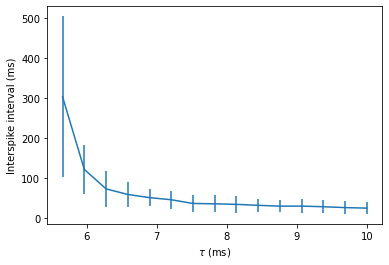

In [39]:
trains = M.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

CPU times: user 1.43 s, sys: 340 ms, total: 1.77 s
Wall time: 1.08 s


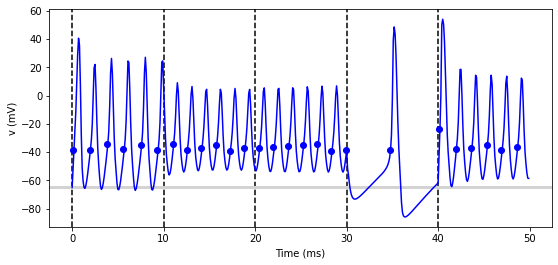

In [44]:
%%time
start_scope()
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
figure(figsize=(9, 4))
for l in range(5):
    group.I = rand()*50*nA
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

CPU times: user 309 ms, sys: 15.6 ms, total: 325 ms
Wall time: 292 ms


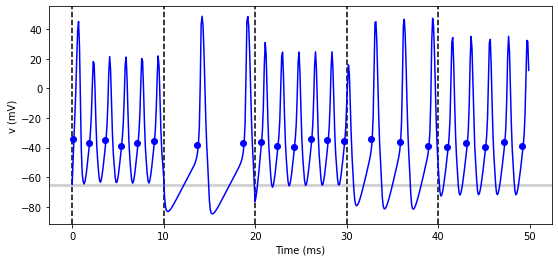

In [47]:
%%time
start_scope()
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
# we replace the loop with a run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
# we keep the loop just to draw the vertical lines
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

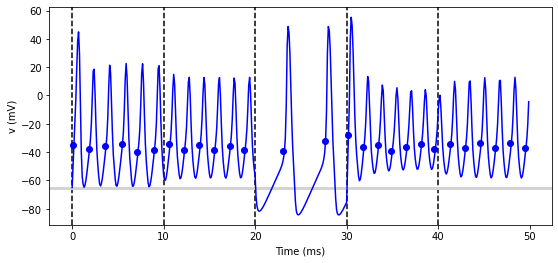

In [53]:
start_scope()
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
# we replace the loop with a network_operation
@network_operation(dt=10*ms)
def change_I():
    group.I = rand()*50*nA
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

WARNING    Variable I is a shared variable but it will be recorded once for every target. [brian2.monitors.statemonitor]


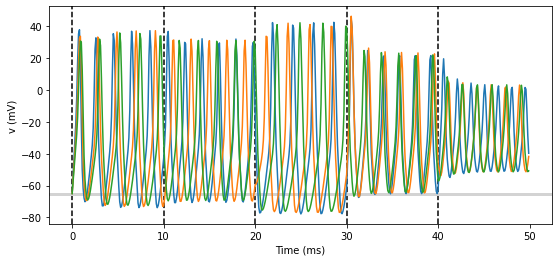

CPU times: user 1.84 s, sys: 303 ms, total: 2.14 s
Wall time: 8.26 s


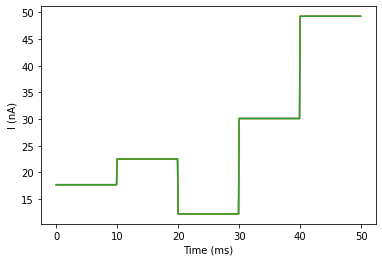

In [57]:
%%time
start_scope()
N = 3
eqs_HH_2 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp (shared)
C : farad
'''
group = NeuronGroup(N, eqs_HH_2,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
# initialise with some different capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, variables=True, record=True)
# we go back to run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)');
plt.show()

plot(statemon.t/ms, statemon.I.T/nA, '-')
xlabel('Time (ms)')
ylabel('I (nA)');

### Adding Input

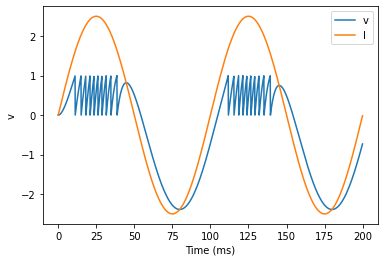

In [58]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
eqs = '''
dv/dt = (I-v)/tau : 1
I = A*sin(2*pi*f*t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

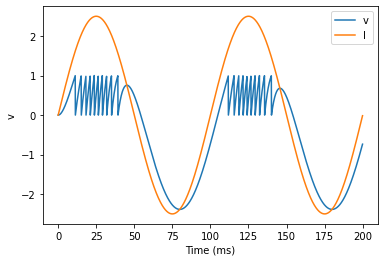

In [59]:
# recorded and saved in a file
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Create a TimedArray and set the equations to use it
t_recorded = arange(int(200*ms/defaultclock.dt))*defaultclock.dt
I_recorded = TimedArray(A*sin(2*pi*f*t_recorded), dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

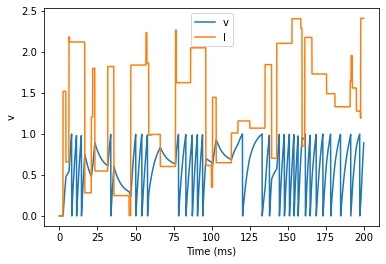

In [60]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Let's create an array that couldn't be
# reproduced with a formula
num_samples = int(200*ms/defaultclock.dt)
I_arr = zeros(num_samples)
for _ in range(100):
    a = randint(num_samples)
    I_arr[a:a+100] = rand()
I_recorded = TimedArray(A*I_arr, dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

### LIF with threshold adaptation
Example from Brian2 tutorials:
https://brian2.readthedocs.io/en/stable/examples/adaptive_threshold.html

New input object: SpikeGenerator

#### Excersise
Plot I-f curve for Adaptive LIF neuron

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s


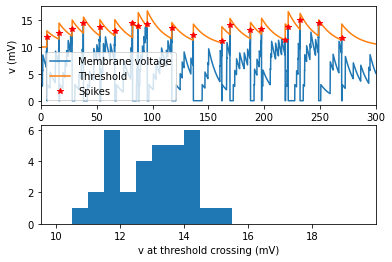

In [5]:
b2.start_scope()
tau_v = 10 * b2.ms
tau_th = 15 * b2.ms
v_reset = 0 * b2.mV
theta = 3 * b2.mV
v_th_0 = 10 * b2.mV
eqs = '''
dv/dt = -v/tau_v : volt
dvt/dt = (v_th_0-vt)/tau_th : volt
'''

reset = '''
v = v_reset
vt += theta
'''

IF = b2.NeuronGroup(1, model=eqs, reset=reset, threshold='v>vt',
                 method='exact')
IF.vt = 10*b2.mV
PG = b2.PoissonGroup(1, 500 * b2.Hz)

w_syn = 3 * b2.mV
C = b2.Synapses(PG, IF, on_pre='v += w_syn')
C.connect()

Mv = b2.StateMonitor(IF, 'v', record=True)
Mvt = b2.StateMonitor(IF, 'vt', record=True)
# Record the value of v when the threshold is crossed
M_crossings = b2.SpikeMonitor(IF, variables='v')
b2.run(0.5*b2.second, report='text')

b2.subplot(2, 1, 1)
b2.plot(Mv.t / b2.ms, Mv[0].v / b2.mV, label='Membrane voltage')
b2.plot(Mvt.t / b2.ms, Mvt[0].vt / b2.mV, label='Threshold')
b2.plot(M_crossings.t/ b2.ms, M_crossings.v / b2.mV, '*r', label='Spikes')
b2.legend()
b2.ylabel('v (mV)')
b2.xlabel('t (ms)')
# zoom in on the first 100ms
b2.xlim(0, 300)
b2.subplot(2, 1, 2)
b2.hist(M_crossings.v / b2.mV, bins=np.arange(10, 20, 0.5))
b2.xlabel('v at threshold crossing (mV)')
b2.show()

In [ ]:
from brian2 import *

start_scope()

N = 8
eqs = '''
dv/dt = -v/(10*ms) : volt
dvt/dt = (10*mV-vt)/(15*ms) : volt
'''

reset = '''
v = 0*mV
vt += 3*mV
'''

IF = NeuronGroup(N, model=eqs, reset=reset, threshold='v>vt',
                 method='exact')
IF.vt = 10*mV
PG = PoissonGroup(N, linspace(0, 700, 8, endpoint=True) * Hz)

C = Synapses(PG, IF,  on_pre='v += 3*mV')
C.connect(j='i')

Mv = StateMonitor(IF, 'v', record=True)
Mvt = StateMonitor(IF, 'vt', record=True)
# Record the value of v when the threshold is crossed
M_crossings = SpikeMonitor(IF, variables='v')
run(2*second, report='text')

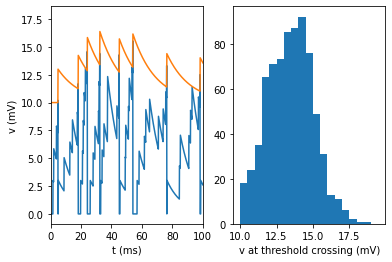

In [19]:
subplot(1, 2, 1)
plot(Mv.t / ms, Mv[5].v / mV)
plot(Mvt.t / ms, Mvt[5].vt / mV)
ylabel('v (mV)')
xlabel('t (ms)')
# zoom in on the first 100ms
xlim(0, 100)
subplot(1, 2, 2)
hist(M_crossings.v / mV, bins=np.arange(10, 20, 0.5))
xlabel('v at threshold crossing (mV)')
show()

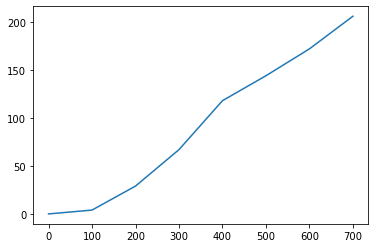

In [26]:
st = M_crossings.spike_trains()
plot(PG.rates, [len(st[s]) for s in st])

### Mutual inhibition
A simple network where two neurons inhibit each other and oscillate in anti-phase

#### Excercise
Add threshold adaptaion to the neurons as in the cell above.
Make the neurons fire not a single spike, but spike bursts in anti-phase.

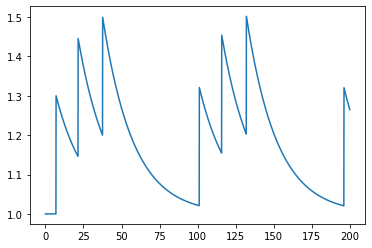

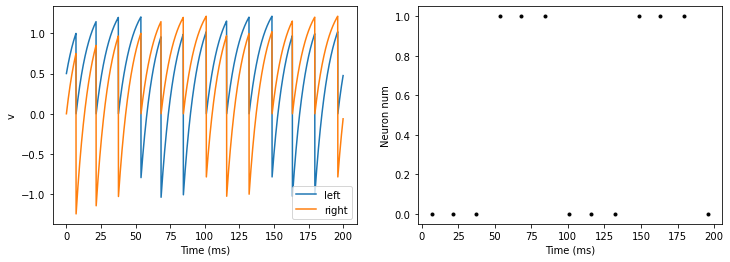

In [122]:
start_scope()
I = 1.5
tau = 10. * ms
tau1 = 20. * ms
vt0 = 1.
theta = .3
eqs='''
dv/dt = (I-v)/tau : 1
dvt/dt = (vt0-vt)/tau1 : 1
'''
G = NeuronGroup(2, eqs, threshold='v>vt', reset='v=0', method='exact')
G.vt = [1, 1]
G.v = [.5, .0]

w_syn = -2.
S = Synapses(
    G, G, 
    on_pre='''
    v_post += w_syn
    vt_pre += theta
    ''',
)
S.connect(condition='i!=j')
v_mon = StateMonitor(G, ['v', 'vt'],record=True)
s_mon = SpikeMonitor(G)
net = Network(G,S,v_mon,s_mon)
net.run(200*ms)
# plot_v(v_mon)
# visualise_connectivity(S)
# plt.show()
plt.plot(v_mon.t/ms, v_mon.vt[0])
plt.show()
plot_v_spikes(v_mon, s_mon)

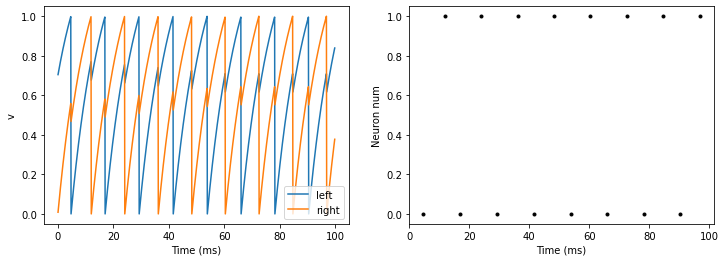

In [44]:
b2.start_scope()
I = 1.5
vt = 1
eqs='''
    dv/dt=(I-v)/tau : 1
    tau : second
    '''
G = b2.NeuronGroup(2, eqs, threshold='v>vt', reset='v = 0', method='linear')
G.tau=[10,10]*b2.ms
G.v='rand()'
w_syn = -0.1
S = b2.Synapses(G, G, on_pre='v += w_syn')
S.connect(i=[0,1], j=[1,0])
#S.connect(i=1,j=0)
v_mon = b2.StateMonitor(G, 'v',record=True)
s_mon = b2.SpikeMonitor(G)
net = b2.Network(G,S,v_mon,s_mon)
net.run(100*b2.ms)
plot_v_spikes(v_mon, s_mon)